### Import necessary libraries

In [1]:
# import necessary libraries
from skimage.external import tifffile
from scipy.ndimage import label
from matplotlib import pyplot as plt
import pandas as pd
import scipy.ndimage as ndi
import glob
import h5py
import os
import numpy as np

/home/betalab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Define functions

In [2]:
def load_tiff_sequence ( imdir, imgtype='tiff', range=None ):
    """
    load tiff sequence stored in the same directory
    e.g. 
    vol = load_tiff_sequence (imgdir, '.png', range=[])
    """

    imlist = glob.glob( imdir + '*.' + imgtype )
    imlist.sort() # sort numerically
    
    if range is not None:
        imlist = imlist[ range[0]:range[1]]
        
    #get image properties by reading the first image
    im = tifffile.imread(imlist[0])
    imsize_x = im.shape[1]
    imsize_y = im.shape[0]
    imsize_z = len( imlist )
    imsize = ( imsize_z, imsize_y, imsize_x )
    imtype = im.dtype
    
    stack = np.zeros( imsize, dtype=imtype )
    for (i, impath) in enumerate(imlist):
        im = tifffile.imread( impath )
        stack[i,:,:] = im
        
    return stack

In [3]:
def write_as_hdf5( stack, h5name, destname, 
                   chunks_enabled=True, chunksize=None,
                   attributes=None ):
    """
    e.g.
    write_as_hdf5(vol, 'test.hdf5', 'resolution_0', True, (100,100,100))
    """
    if chunks_enabled:
        if chunksize is None:
            chunks = True
        else:
            chunks = chunksize
    else:
        chunks = None
        
    with h5py.File( h5name, 'w', driver='stdio' ) as hf:
        data = hf.create_dataset (destname,
                                  chunks=chunks,
                                  data=stack )
        if attributes is not None:
            for key, value in attributes.items():
                data.attrs[key] = value

In [4]:
def ask_hdf5_size( h5name, dsetname=None ):
    
    # obtain file handle
    hf = h5py.File( h5name, 'r' )
    
    if dsetname is None:
        # get the name of the 0th dataset
        dsetname = list( hf.keys() )[0]
        dset = hf[ dsetname ]
    else:
        # get dataset
        dset = hf[ dsetname ]
    
    # print size
    print( "Data set size:", dset.shape )
    
    # close handle
    hf.close()

In [5]:
def load_hdf5( h5name, dsetname=None, multichannel=True ):
    
    # obtain file handle
    hf = h5py.File( h5name, 'r' )
    
    if dsetname is None:
        # get the name of the 0th dataset
        dsetname = list( hf.keys() )[0]
        dset = hf[ dsetname ]
    else:
        # get dataset
        dset = hf[ dsetname ]
    
    if multichannel:
        # load data as numpy array
        data = dset[ :, :, :, 0] # 0th channel = cells
        #data = dset[ :, :, :, 0] # 0th channel = cells
    else:
        data = dset[ :, :, :] # 0th channel = cells
        #data = dset[ :, :, :] # 0th channel = cells

    # close handle
    hf.close()
    
    return data

In [6]:
def calculate_prob_hdf5(file_list):
    
    # load probabiltiy image
    prob = load_hdf5( file, "probability", multichannel=True )
    print (prob.shape)
    
    ### Binarize probability image
    thresh = 0.5 * 255
    binary = ( prob > thresh )
    print ("Total volume of detected signals:", binary.sum()*8.25*8.25*10)
    
    # this defines "connectivity" between voxels
    struct = ndi.generate_binary_structure( 3, 3 )
        
    # Label isolated objects
    objects, num_objects = label( binary, struct )
    print( "Number of detected objects:", objects.max() )
        
    # make binary into uint16
    #binary16 = (255*binary).astype( 'uint16' )
    
    # export as tiff
    #basename = os.path.basename(file)
    #filename = rootdir[:-5] + "tiff/" + basename[:-20] + "CG_p50_639.tif"
    #tifffile.imsave( filename, binary16 )

    ### Find center of mass
    ids = np.arange( 1, num_objects+1 )
    coms = ndi.center_of_mass( binary, objects, ids )
    
    # convert to numpy array
    coms = np.array( coms )
    
    # Compute volume of each object
    unique, counts = np.unique( objects, return_counts=True )
    # remove 0
    unique = unique[1:]
    volume = counts[1:]*8.25*8.25*10
    
    # create empty dataframe
    df = pd.DataFrame()
    
    # colum "ID"
    df['ID'] = unique
    
    # column "X", "Y", "Z"
    df['X'] = coms[ :, 2 ]
    df['Y'] = coms[ :, 1 ]
    df['Z'] = coms[ :, 0 ]
    
    # colum "volume"
    df['Volume'] = volume
    
    # save as csv
    basename = os.path.basename(file)
    filename = rootdir[:-5] + "csv/" + basename[:-16] + "CG_p50.csv"
    df.to_csv( filename, index=False, float_format='%.2f' )

### Load HDF5 (probability image)

In [7]:
# Define root diretory
rootdir = "/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/"

In [8]:
# get files which ends with 'probability'
file_list = glob.glob( rootdir + "*181226*probability37.h5" )
print( file_list )

['/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_BSA_Clo_05_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_BSA_Clo_06_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_BSA_Clo_07_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_BSA_Clo_08_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_BSA_Sal_01_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_BSA_Sal_02_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_BSA_Sal_03_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_BSA_Sal_04_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_Tb_Clo_13_probability37.h5', '/media/betalab/MP_0151/HDF5/180911_A549_dose_hdf5/181226_A549-mCh_Tb_Clo_14_probability37.h5', '/media/betalab/MP_0151/HDF5/18

In [9]:
# loop through all files
for file in file_list:
    ask_hdf5_size( file, dsetname=None )
    raw = load_hdf5(file, multichannel=False)
    print (file[50:-3])
    calculate_prob_hdf5(file)

Data set size: (541, 2160, 2560, 4)
181226_A549-mCh_BSA_Clo_05_probability37
(541, 2160, 2560)
Total volume of detected signals: 83799911.25
Number of detected objects: 1329
Data set size: (551, 2160, 2560, 4)
181226_A549-mCh_BSA_Clo_06_probability37
(551, 2160, 2560)
Total volume of detected signals: 36133700.625
Number of detected objects: 901
Data set size: (701, 2160, 2560, 4)
181226_A549-mCh_BSA_Clo_07_probability37
(701, 2160, 2560)
Total volume of detected signals: 64936389.375
Number of detected objects: 1230
Data set size: (561, 2160, 2560, 4)
181226_A549-mCh_BSA_Clo_08_probability37
(561, 2160, 2560)
Total volume of detected signals: 75322046.25
Number of detected objects: 1353
Data set size: (511, 2160, 2560, 4)
181226_A549-mCh_BSA_Sal_01_probability37
(511, 2160, 2560)
Total volume of detected signals: 9076815.0
Number of detected objects: 244
Data set size: (671, 2160, 2560, 4)
181226_A549-mCh_BSA_Sal_02_probability37
(671, 2160, 2560)
Total volume of detected signals: 112

# 190703

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dabest

#Excelを扱うのに必要なライブラリ
import os, csv, openpyxl, glob

print("We're using DABEST v{}".format(dabest.__version__))

We're using DABEST v0.2.4


        BSA_Con      BSA_Clo      Tb_Con       Tb_Clo  BSA_Con.1  BSA_Clo.1  \
0  9.076815e+06  83799911.25   789318090  450884115.0        244       1329   
1  1.128544e+07  36133700.63  2212154443  175868055.0        292        901   
2  1.352810e+07  64936389.38  2924828713  913084981.9        296       1230   
3  9.031894e+05  75322046.25  1920170402  407228146.9         62       1353   

   Tb_Con.1  Tb_Clo.1  
0      6518      7364  
1     12516      2163  
2     12156     11135  
3     12688      6393  


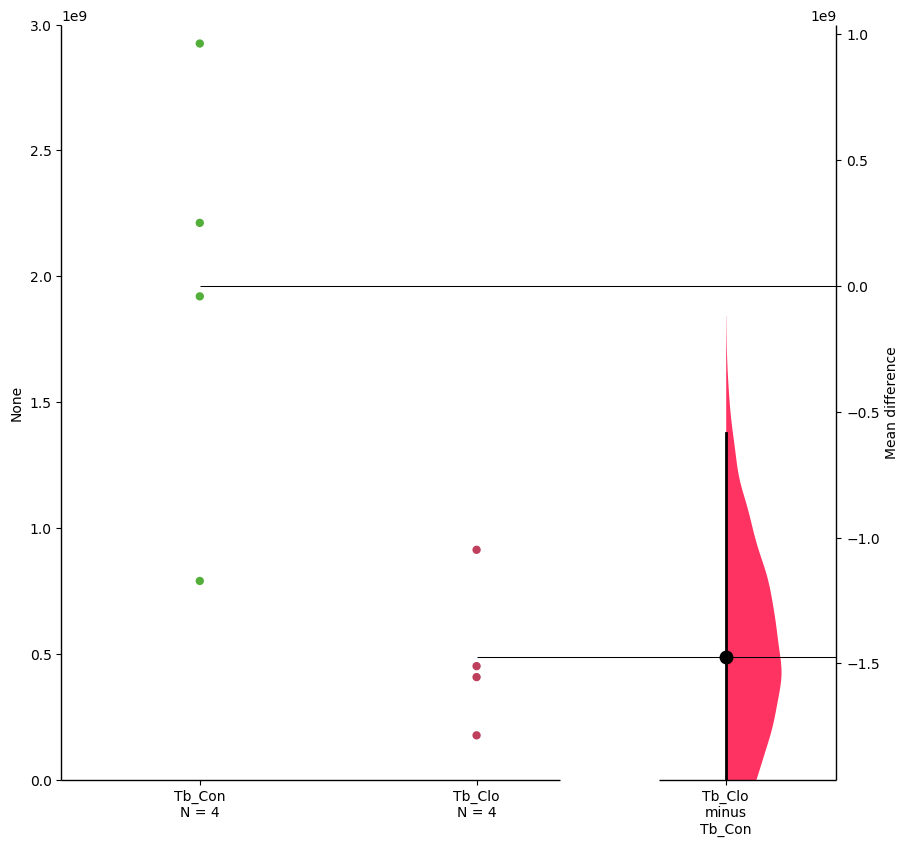

In [21]:
# Load the csv dataset
A549 = pd.read_csv("/Users/shimpei.i.kubota/Dropbox/PythonCode/190700_labnote/181226_Clodoronate/181226_Clodronate.csv")

df_A549 = A549.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7]]

print (df_A549)

# Load the above data into 'dabest'
A549_dabest = dabest.load(df_A549, idx=("Tb_Con", "Tb_Clo"), ci=95)
A549_dabest.mean_diff.plot(fig_size=(10, 10), custom_palette="prism",
                           swarm_ylim=(0, 3000000000))

plt.savefig("190703_A549_Clodronate_TbVol_01.png")
plt.savefig("190703_A549_Clodronate_TbVol_01.pdf")


        BSA_Con      BSA_Clo      Tb_Con       Tb_Clo  BSA_Con.1  BSA_Clo.1  \
0  9.076815e+06  83799911.25   789318090  450884115.0        244       1329   
1  1.128544e+07  36133700.63  2212154443  175868055.0        292        901   
2  1.352810e+07  64936389.38  2924828713  913084981.9        296       1230   
3  9.031894e+05  75322046.25  1920170402  407228146.9         62       1353   

   Tb_Con.1  Tb_Clo.1  
0      6518      7364  
1     12516      2163  
2     12156     11135  
3     12688      6393  


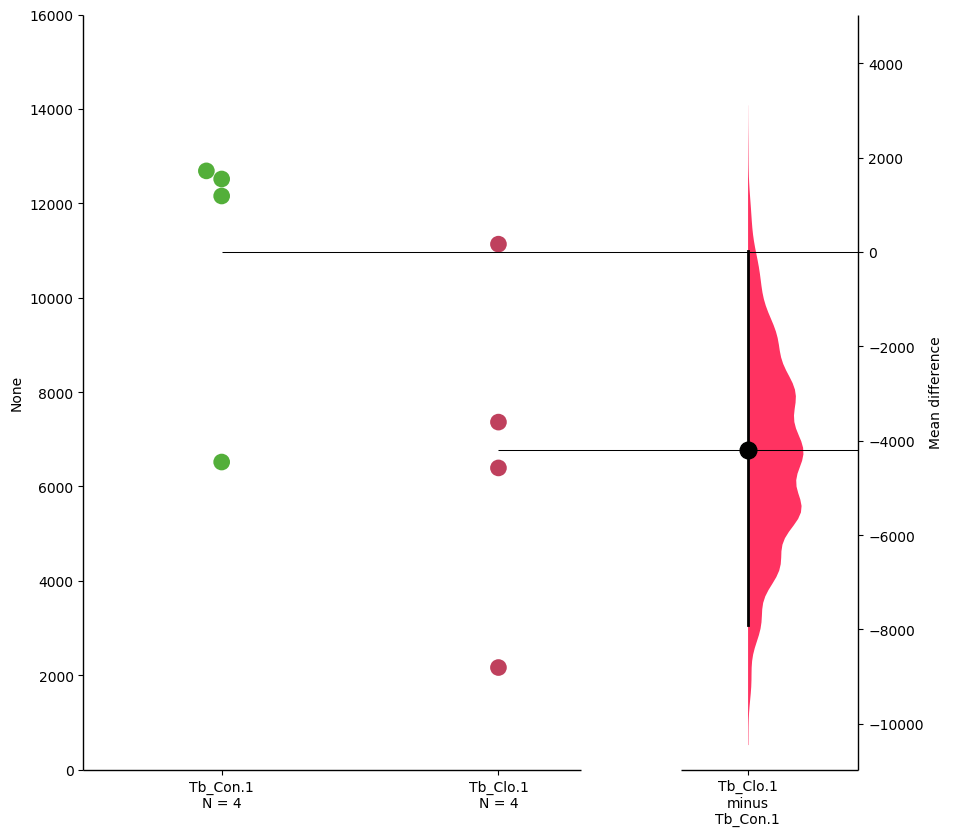

In [24]:
# Load the csv dataset
A549 = pd.read_csv("/Users/shimpei.i.kubota/Dropbox/PythonCode/190700_labnote/181226_Clodoronate/181226_Clodronate.csv")

df_A549 = A549.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7]]

print (df_A549)

# Load the above data into 'dabest'
A549_dabest = dabest.load(df_A549, idx=("Tb_Con.1", "Tb_Clo.1"), ci=95)
A549_dabest.mean_diff.plot(fig_size=(10, 10), custom_palette="prism",
                           raw_marker_size=12, es_marker_size=12, swarm_ylim=(0, 16000))

plt.savefig("190703_A549_Clodronate_TbNum_02.png")
plt.savefig("190703_A549_Clodronate_TbNum_02.pdf")



        BSA_Con      BSA_Clo      Tb_Con       Tb_Clo  BSA_Con.1  BSA_Clo.1  \
0  9.076815e+06  83799911.25   789318090  450884115.0        244       1329   
1  1.128544e+07  36133700.63  2212154443  175868055.0        292        901   
2  1.352810e+07  64936389.38  2924828713  913084981.9        296       1230   
3  9.031894e+05  75322046.25  1920170402  407228146.9         62       1353   

   Tb_Con.1  Tb_Clo.1  
0      6518      7364  
1     12516      2163  
2     12156     11135  
3     12688      6393  


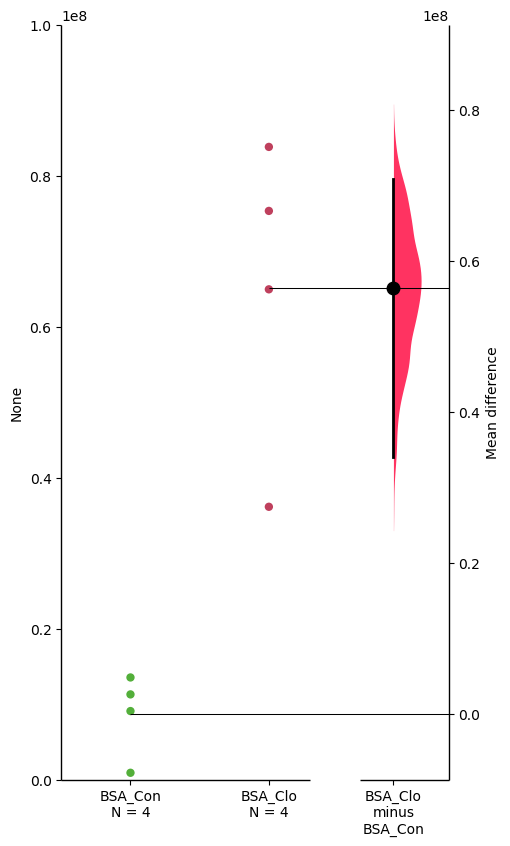

In [20]:
# Load the csv dataset
A549 = pd.read_csv("/Users/shimpei.i.kubota/Dropbox/PythonCode/190700_labnote/181226_Clodoronate/181226_Clodronate.csv")

df_A549 = A549.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7]]

print (df_A549)

# Load the above data into 'dabest'
A549_dabest = dabest.load(df_A549, idx=("BSA_Con", "BSA_Clo"), ci=95)
A549_dabest.mean_diff.plot(fig_size=(5, 10), custom_palette="prism",
                           swarm_ylim=(0, 100000000))

plt.savefig("190703_A549_Clodronate_BSAVol_03.png")
plt.savefig("190703_A549_Clodronate_BSAVol_03.pdf")


        BSA_Con      BSA_Clo      Tb_Con       Tb_Clo  BSA_Con.1  BSA_Clo.1  \
0  9.076815e+06  83799911.25   789318090  450884115.0        244       1329   
1  1.128544e+07  36133700.63  2212154443  175868055.0        292        901   
2  1.352810e+07  64936389.38  2924828713  913084981.9        296       1230   
3  9.031894e+05  75322046.25  1920170402  407228146.9         62       1353   

   Tb_Con.1  Tb_Clo.1  
0      6518      7364  
1     12516      2163  
2     12156     11135  
3     12688      6393  


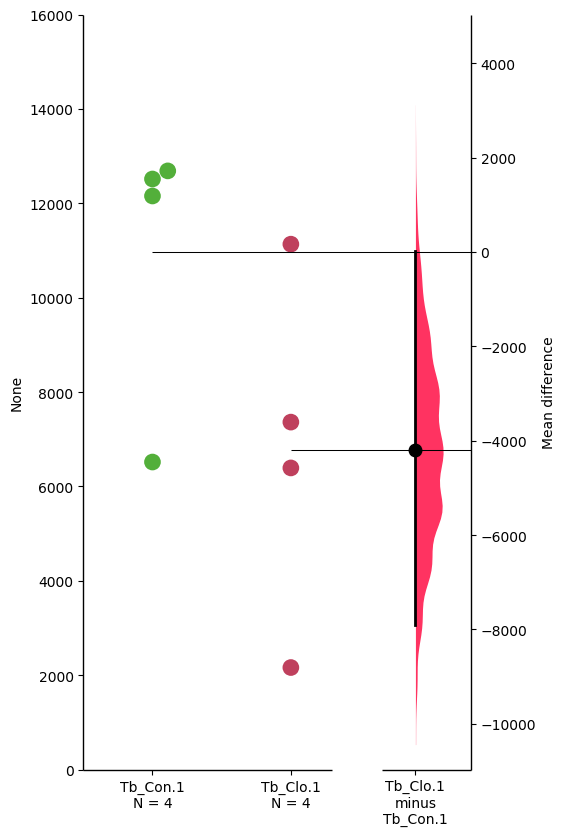

In [23]:
# Load the csv dataset
A549 = pd.read_csv("/Users/shimpei.i.kubota/Dropbox/PythonCode/190700_labnote/181226_Clodoronate/181226_Clodronate.csv")

df_A549 = A549.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7]]

print (df_A549)

# Load the above data into 'dabest'
A549_dabest = dabest.load(df_A549, idx=("Tb_Con.1", "Tb_Clo.1"), ci=95)
A549_dabest.mean_diff.plot(fig_size=(5, 10), raw_marker_size=12, es_marker_size=12,
                           custom_palette="prism",swarm_ylim=(0, 16000))

plt.savefig("190703_A549_Clodronate_BSANum_04.png")
plt.savefig("190703_A549_Clodronate_BSANum_04.pdf")

